In [2]:
%matplotlib inline
import os
import math 
import numpy as np
import pandas as pd 
import seaborn as sns
import random
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, spearmanr, gaussian_kde
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import scale, StandardScaler
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from matplotlib.colors import rgb2hex
import warnings
sns.set_style('white')
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 999
warnings.filterwarnings('ignore')

ahba_dir     = '/Users/kanaaax/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/dataframes/AHBA/'
gsea_dir     = '/Users/kanaaax/Desktop/GSEA'
permute_dir  = '/Users/kanaaax/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/dataframes/permutations'
save_fig_dir = '/Users/kanaaax/Google Drive/TS-EUROTRAIN/Papers/2019_QSM_paper/Figures_python_v4'

background_genes = pd.read_csv(os.path.join(ahba_dir,'background_gene_list.txt'), sep='\t').GeneSymbol.values


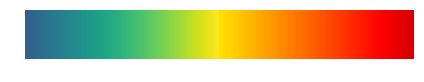

In [3]:
#cmaps
from matplotlib import colors
cmap_drysdale = colors.ListedColormap(['#00ffff', '#00afff','#0000ff', '#260000', '#530000','#fe0000', '#ff6a00', '#ffff00'])
cmap_ted = colors.ListedColormap(['#00ffff', '#00afff','#0000ff', '#260000', '#530000','#fe0000', '#ff6a00','#ffff00', '#ffffff'])
cmap_rdbu = colors.ListedColormap(['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4'][::-1])
cmap_rdbu2 = colors.ListedColormap(['#cb1a1e', '#e1817f', '#f1bebe', '#e0f3f8', '#91bfdb', '#4575b4'][::-1])

first = int((128*2)-np.round(255*(1.-0.50)))
second = (256-first)
colors2 = plt.cm.viridis(np.linspace(0.2, .98, first))
colors3 = plt.cm.YlOrRd(np.linspace(0.3, 0.8, second))
colors4 = plt.cm.PuBu(np.linspace(0., 0.25, second))

colors2 = plt.cm.viridis(np.linspace(0.3, 1, first))
colors3 = plt.cm.hot_r(np.linspace(0.3, 0.7, second))

cols = np.vstack((colors2,colors3))
cmap_gradient = colors.LinearSegmentedColormap.from_list('my_colormap', cols)

num = 256
gradient = range(num)
for x in range(5):
    gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap=cmap_gradient, interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

plt.show()





In [4]:
def return_pls(samples,features, nuc):

    pls1 = pd.read_csv(os.path.join(ahba_dir, 'ahba_data/stats/%snuc_PLS1_weights_%s_chi_%s.csv'%(nuc,samples,features)), header=None).set_index(0)
    pls2 = pd.read_csv(os.path.join(ahba_dir, 'ahba_data/stats/%snuc_PLS2_weights_%s_chi_%s.csv'%(nuc,samples,features)), header=None).set_index(0)
    pls3 = pd.read_csv(os.path.join(ahba_dir, 'ahba_data/stats/%snuc_PLS3_weights_%s_chi_%s.csv'%(nuc,samples,features)), header=None).set_index(0)

    del pls1.index.name
    del pls2.index.name
    del pls3.index.name
    
    
    for df in [pls1,pls2,pls3]:
        
        q1=np.quantile(df[2], 0.05)
        q2=np.quantile(df[2], 0.95)
        
        df['quantiles']      = [i if i < q1 or i > q2 else np.nan for i in df[2]]
        df['non_quantiles']  = [np.nan if i < q1 or i > q2 else i for i in df[2]]
    
    return pls1, pls2, pls3

    
def return_score(samples,features,nuc):

    pls1 = pd.read_csv(os.path.join(ahba_dir, 'ahba_data/stats/%snuc_PLS1_scores_%s_chi%s.csv'%(nuc,samples,features)), header=None)
    pls2 = pd.read_csv(os.path.join(ahba_dir, 'ahba_data/stats/%snuc_PLS2_scores_%s_chi%s.csv'%(nuc,samples,features)), header=None)
    pls3 = pd.read_csv(os.path.join(ahba_dir, 'ahba_data/stats/%snuc_PLS3_scores_%s_chi%s.csv'%(nuc,samples,features)), header=None)
    chi  = pd.read_csv(os.path.join(ahba_dir, 'ahba_data/stats/%snuc_chi_%s%s.csv'%(nuc,samples[4:],features)), header=None)#.set_index(0)
    del pls1.index.name
    del pls2.index.name
    del pls3.index.name
    del chi.index.name
    
    return pls1, pls2,pls3, chi


motor_pls1, motor_pls2, motor_pls3     = return_pls('ahba20737', 'STR3_MOTOR_tstat_CP_1mm',  '48')
exec_pls1, exec_pls2, exec_pls3        = return_pls('ahba20737', 'STR3_EXEC_tstat_CP_1mm',  '48')
limbic_pls1, limbic_pls2, limbic_pls3  = return_pls('ahba20737', 'STR3_LIMBIC_tstat_CP_1mm',  '40')

motor_scores_pls1, motor_scores_pls2, motor_scores_pls3, motor_chi = return_score('ahba20737', 'STR3_MOTOR_tstat_CP_1mm', 48)
exec_scores_pls1, exec_scores_pls2, exec_scores_pls3,exec_chi = return_score('ahba20737', 'STR3_EXEC_tstat_CP_1mm',  48)
limbic_scores_pls1, limbic_scores_pls2, limbic_scores_pls3,limbic_chi = return_score('ahba20737', 'STR3_LIMBIC_tstat_CP_1mm',  40)



In [5]:
concat_quant = pd.DataFrame([motor_pls1['quantiles'].values, motor_pls2['quantiles'].values, motor_pls3['quantiles'].values, 
                             exec_pls1['quantiles'].values, exec_pls2['quantiles'].values,   exec_pls3['quantiles'].values,
                             limbic_pls1['quantiles'].values, limbic_pls2['quantiles'].values, limbic_pls3['quantiles'].values
                           ]).T
concat_quant.columns = ['motor1', 'motor2', 'motor3', 'exec1', 'exec2', 'exec3', 'limbic1', 'limbic2', 'limbic3']

concat_nonquant = pd.DataFrame([motor_pls1['non_quantiles'].values, motor_pls2['non_quantiles'].values, motor_pls3['non_quantiles'].values, 
                             exec_pls1['non_quantiles'].values, exec_pls2['non_quantiles'].values,   exec_pls3['non_quantiles'].values,
                             limbic_pls1['non_quantiles'].values, limbic_pls2['non_quantiles'].values, limbic_pls3['non_quantiles'].values
                           ]).T
concat_nonquant.columns = ['motor1', 'motor2', 'motor3', 'exec1', 'exec2', 'exec3', 'limbic1', 'limbic2', 'limbic3']



#scaler = preprocessing.MinMaxScaler()
#concat_pls_scale = pd.DataFrame(scaler.fit_transform(concat_pls), columns=concat_pls.columns, index=concat_pls.index)


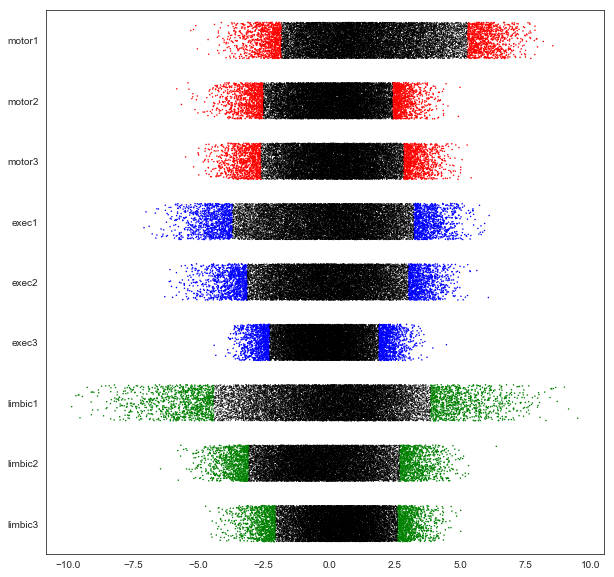

In [6]:
f, ax = plt.subplots(figsize=(10, 10))

palette = ['r', 'r', 'r', 'b', 'b','b', 'g', 'g', 'g' ]

size    = 1.5
jitter  = 0.3
orient  = 'h'
sns.stripplot(data= concat_quant, palette=palette, orient = orient, jitter = jitter, size = size)
sns.stripplot(data= concat_nonquant, color='k', orient =orient, jitter = jitter, size = 1)

In [7]:
def plot_boot(pls, label, c= "#FA966B"):
    
    boot=pls[2]
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    sns.set_style("white")
    g = sns.distplot(boot, color='b', hist=1, bins = 30, norm_hist=1, kde_kws={'linewidth': 0},
                    hist_kws={"histtype": "barstacked", "linewidth": 0.3,
                              "alpha": 1, "color": c})

    q1=np.quantile(boot, 0.05)
    q2=np.quantile(boot, 0.95)
    plt.axvline(q1, color='k', linestyle='-.', linewidth=1)
    plt.axvline(q2, color='k', linestyle='-.', linewidth=1)
    #plt.xlim(-8,8)
    sns.despine(left=1)
    print q1,q2
    #histtype : {'bar', 'barstacked', 'step', 'stepfilled'}, optional
    
    glist5 = [i for i in pls.index if pls.loc[i][2] < np.round(q1,2) ]
    glist95 = [i for i in pls.index if pls.loc[i][2] > np.round(q2,2) ]
    
    print 'n_genes', len(glist5),  len(glist95), 
    
    fig.savefig(os.path.join(save_fig_dir,'PLOT_BOOT_%s_%s.png'%(label,nuc)), bbox_inches='tight', transparent = 1, dpi = 500)
    
    return glist5, glist95

In [8]:
def plot_boot_dist(boot,cmap,fname):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    sns.set_style("white")
    #sns.distplot(boot, color=cmap, kde=0, bins =75)
    plt.hist(boot, color=cmap, bins =75)
    q1=np.quantile(boot, 0.05)
    q2=np.quantile(boot, 0.95)
    qm=np.quantile(boot, 0.5)
    plt.axvline(q1, color='k', linestyle='-.', linewidth=2, ymax=0.75)
    plt.axvline(q2, color='k', linestyle='-.', linewidth=2, ymax=0.75)
    #plt.axvline(qm, color='k', linestyle='-', linewidth=2, ymax=0.75)
    #plt.xlim(-6,8)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize=20, weight='bold')
    plt.yticks(fontsize=20, weight='bold')

    sns.despine(left=0,right=0,top=0)
    
    fig.savefig(os.path.join(save_fig_dir,'dist_boot_%s.png'%fname), bbox_inches='tight', transparent = 1, dpi = 500)

    print q1,qm,q2
    
    glist5 = [i for i in pd.DataFrame(boot).index if pd.DataFrame(boot).loc[i][2] < np.round(q1,2) ]
    glist95 = [i for i in pd.DataFrame(boot).index if pd.DataFrame(boot).loc[i][2] > np.round(q2,2) ]
    
    print 'n_genes', len(glist5),  len(glist95), 

    
def return_genes(boot,fname):
    
    q1=np.quantile(boot, 0.05)
    q2=np.quantile(boot, 0.95)
    
    glist5 = [i for i in pd.DataFrame(boot).index if pd.DataFrame(boot).loc[i][2] < np.round(q1,2) ]
    glist95 = [i for i in pd.DataFrame(boot).index if pd.DataFrame(boot).loc[i][2] > np.round(q2,2) ]
    
    
    pd.DataFrame(glist5).to_csv(os.path.join(ahba_dir,'ahba_data/PLS_GENES/%s_DOWNREGULATED.csv'%fname),index=False, header=None)
    pd.DataFrame(glist95).to_csv(os.path.join(ahba_dir,'ahba_data/PLS_GENES/%s_UPREGULATED.csv'%fname),index=False, header=None)
    
    return glist5,glist95

-1.8268717999999997 1.132254 5.281083400000001
n_genes 1032 1039 -1.8268717999999997 1.132254 5.281083400000001
n_genes 1032 1039


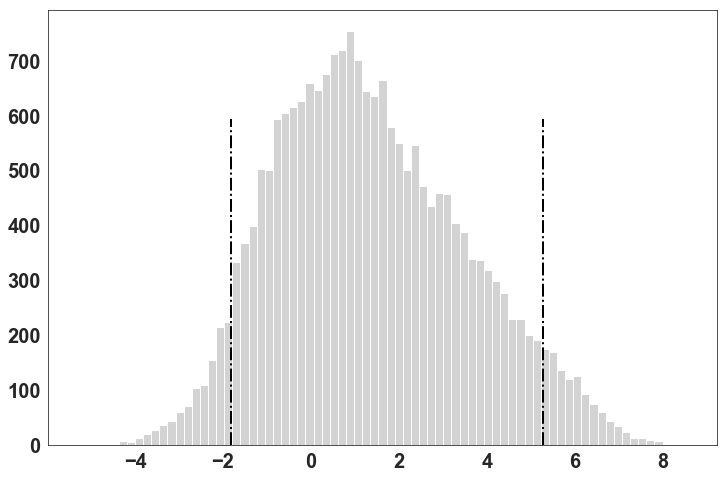

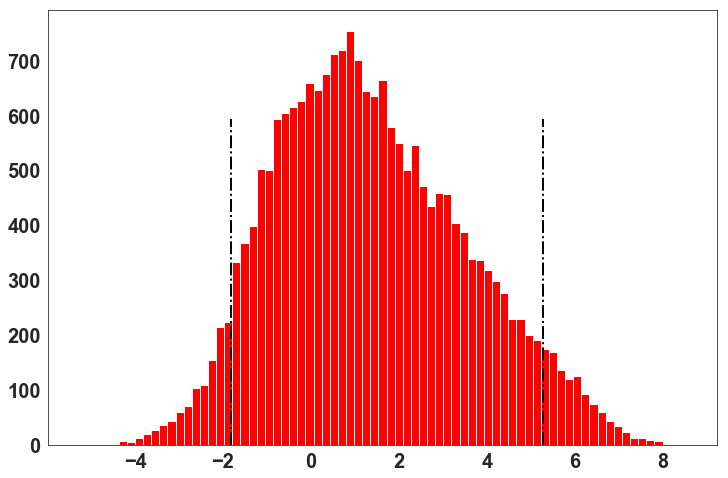

In [9]:
plot_boot_dist(motor_pls1[2], 'lightgray', 'motor_pls1_g')
plot_boot_dist(motor_pls1[2], 'red', 'motor_pls1_r')

-2.51684 0.097585 2.4240914000000013
n_genes 1034 1045 -2.51684 0.097585 2.4240914000000013
n_genes 1034 1045


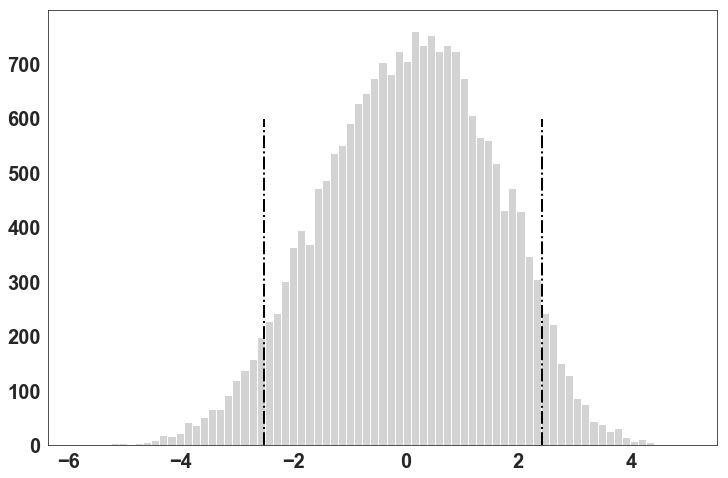

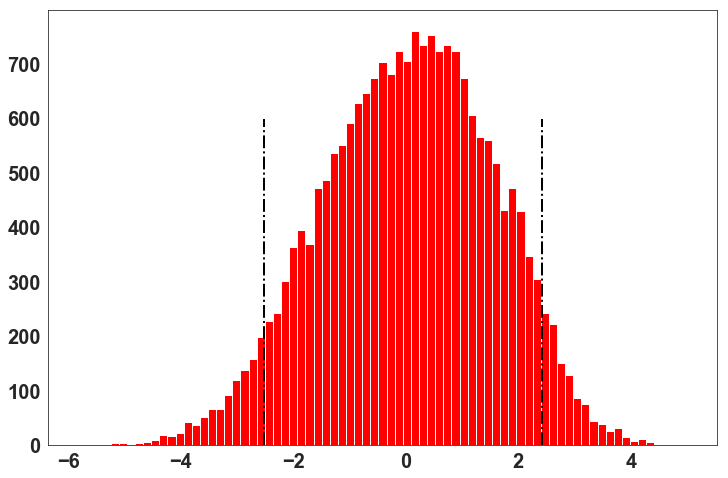

In [10]:
plot_boot_dist(motor_pls2[2], 'lightgray', 'motor_pls2_g')
plot_boot_dist(motor_pls2[2], 'red', 'motor_pls2_r')

In [11]:
motor_pls1_5,motor_pls1_95 = return_genes(motor_pls1[2], 'MOTOR_PLS1')
motor_pls2_5,motor_pls2_95 = return_genes(motor_pls2[2], 'MOTOR_PLS2')
motor_pls3_5,motor_pls3_95 = return_genes(motor_pls3[2], 'MOTOR_PLS3')

In [12]:
exec_pls1_5,exec_pls1_95 = return_genes(exec_pls1[2], 'EXEC_PLS1')
exec_pls2_5,exec_pls2_95 = return_genes(exec_pls2[2], 'EXEC_PLS2')
exec_pls3_5,exec_pls3_95 = return_genes(exec_pls3[2], 'EXEC_PLS3')

In [13]:
limbic_pls1_5,limbic_pls1_95 = return_genes(limbic_pls1[2], 'LIMBIC_PLS1')
limbic_pls2_5,limbic_pls2_95 = return_genes(limbic_pls2[2], 'LIMBIC_PLS2')
limbic_pls3_5,limbic_pls3_95 = return_genes(limbic_pls3[2], 'LIMBIC_PLS3')

In [15]:
def make_pearson(df,chi):
    dfx = pd.DataFrame(pd.concat([df[0], chi[0]], axis =1))
    dfx.columns = ['pls', 'chi']
    print pearsonr(dfx.pls, dfx.chi)

print 'MOTOR'
make_pearson(motor_scores_pls1,motor_chi)
make_pearson(motor_scores_pls2,motor_chi)
make_pearson(motor_scores_pls3,motor_chi)

print 'EXEC'
make_pearson(exec_scores_pls1,exec_chi)
make_pearson(exec_scores_pls2,exec_chi)
make_pearson(exec_scores_pls3,exec_chi)

print 'LIMBIC'
make_pearson(limbic_scores_pls1,limbic_chi)
make_pearson(limbic_scores_pls2,limbic_chi)
make_pearson(limbic_scores_pls3,limbic_chi)



MOTOR
(0.6960195550124835, 3.9698450492887414e-08)
(0.41116334234908986, 0.0036945121922703386)
(0.410482233626682, 0.0037573156573532523)
EXEC
(0.7180798465612169, 9.178921861549668e-09)
(0.47966068456656397, 0.0005613228488274285)
(0.2762849323824618, 0.05731702714676707)
LIMBIC
(0.7010180019197539, 4.7159384915562255e-07)
(0.48950198465487466, 0.0013475089332967754)
(0.3036912484677859, 0.0567705517306749)


In [61]:
pearsonr(motor_scores_pls1[0], chi[0])

ValueError: operands could not be broadcast together with shapes (48,) (40,) 

In [19]:
dfx = pd.DataFrame(pd.concat([motor_scores_pls1[0], motor_chi[0]], axis =1))
dfx.columns = ['pls', 'chi']


(0.6960195550124835, 3.9698450492887414e-08)


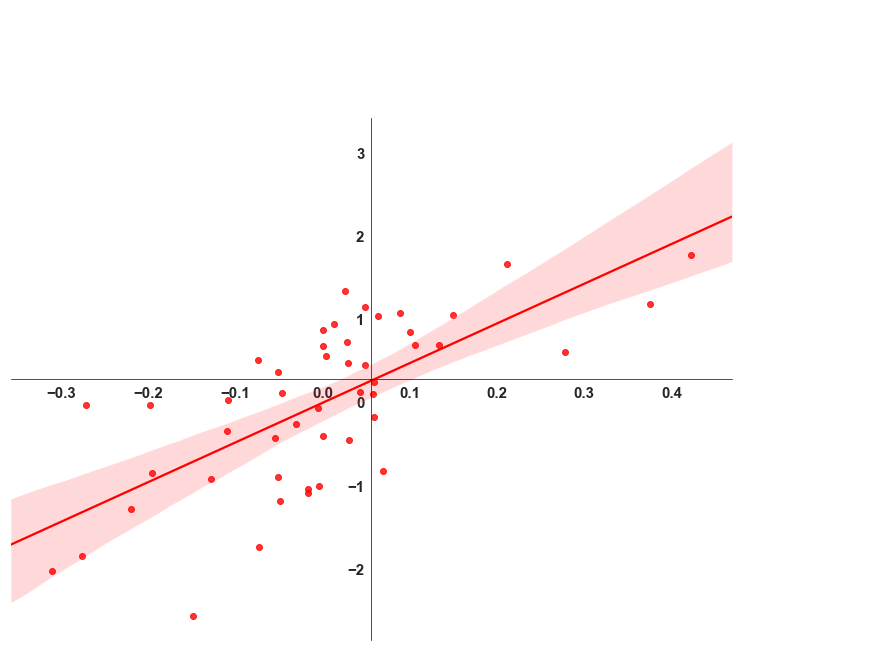

In [54]:
#g = sns.jointplot(dfx.pls, dfx.chi, kind = 'reg', color='r')

g = sns.JointGrid(dfx.pls, dfx.chi)
ax = g.ax_joint
g.plot_joint(sns.regplot,color='r')
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()


print pearsonr(dfx.pls, dfx.chi)
g.fig.set_figwidth(14)
g.fig.set_figheight(10)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
plt.xticks(fontsize=15, weight='bold')
plt.yticks(fontsize=15, weight='bold')
ax.set_ylabel('')    
ax.set_xlabel('')
plt.savefig(os.path.join(save_fig_dir,'PLOT_BOOTCORR_MOTOR_PLS1.png'), bbox_inches='tight', transparent = 1, dpi = 500)


In [30]:
def make_pls_quantile_csv()


for i in exec_pls1_95:
    print i 

JOSD1
PLBD1
ZNFX1
NCF1
ATP5H
CAPN12
LARP4B
CICP8
NDUFS5P7
C1ORF213
CHCHD4
FCER1A
ZDHHC1
PXMP3
CDH22
HIST2H2BF
LOC100132585
GJC1
ADORA2B
ALDH9A1
REEP3
SUCLG2
DDRGK1
ALKBH3
GAS5
NCDN
PEX14
LOC100133660
MED17
LOC100294376
CD36
TBXA2R
CHMP5
SEC14L4
IPO11
URI1
CYFIP2
LOC730134
SHOX2
PLD3
KIF11
LOC650224
PIAS3
OR10P1
CXCL14
EPB41L4A
TYK2
FAM131B
SNF8
ADARB2
RIPK3
ALOX5
DLK2
GPI
CIDECP
COX7A1
CX3CL1
DGUOK
SPIRE2
ROD1
CFL1
C21orf56
C7orf38
ZNF48
HINFP
PNPLA1
OR11H1
SLC16A2
GP6
HHLA2
P2RX6
LAG3
HCAR1
AIDA
HLA_DQA1
NAPSA
OR4F6
C4orf47
LOC645212
C20orf103
NQO1
AP2M1
MCM10
CARD9
SYCE2
HLA_DRB3
CACNA2D3
MACROD2
TMEM101
PVRIG
RPL10
NKX3_2
CUL9
TMEM52
AC022098_3
ROM1
GEMIN5
SLC39A3
SLC16A7
NDUFA3
LOC390760
RPS12
SNRPE
FAM205CP
RPL36AL
RPA2
PMF1
ADRB1
LOC100287987
PFDN4
C8orf54
CCDC132
AC097067_1
ACSM4
PPCS
RP11_110H10_2
RNF180
CYP46A1
HS6ST3
TRPV5
KRTAP12_3
C9orf117
INO80D
C6orf222
PTGER4
ZNHIT2
SERHL
AFM
KLC2
WDR20
RPL22L1
DYNC1H1
TMEM51
PTGDS
PRAF2
CRB1
C9orf119
HAL
LOC100127891
DCTN6
MRGPRD
CORO1A

In [293]:
GO_GABA = ['GABRA4', 'GABRA6', 'GABRA1', 'GABRG2', 'GABRB2', 'GABRP', 'GABRA2', 'GABRA3', 'GABRE', 'GABRD', 'GABRR1', 'GABRQ', 'GABRB1', 'GABRR3', 'GABRR2', 'GABRA5', 'GABRB3', 'GABBR2']              

dfx = motor_pls1.drop([1,'quantiles', 'non_quantiles'], axis =1).sort_values(by=[2]).reset_index()#.set_index('index')
dfx = dfx.drop([i for i in dfx.index if dfx.loc[i]['index'] not in GO_GABA ], axis = 0)
dfx



,index,2
11,GABRA4,-4.217921
48,GABRA6,-3.649393
55,GABRA1,-3.601956
58,GABRG2,-3.589977
148,GABRB2,-3.109303
201,GABRP,-2.938067
377,GABRA2,-2.548812
585,GABRA3,-2.229298
890,GABRE,-1.954866
1487,GABRD,-1.578625


In [294]:
11: GABRA4     -4.25
49: GABRA6     -3.66
55: GABRA1     -3.62
62: GABRG2     -3.58
125: GABRB3   -3.1
166: GABRP     -2.9
326: GABRA2  -2.6
531: GABRA3   -2.2
786: GABRE     -2.0
1335: GABRD   -1.6
2921: GABRR1 -0.83
4488: GABRQ  -0.30
5716: GABRB1 0.13
5768: GABRR3 0.15
6376: GABRR2  0.51
6937: GABRA5  0.63
7332: GABRB3  0.62
15596: GABBR2 3.9
  

SyntaxError: invalid syntax (<ipython-input-294-61432c70d327>, line 1)

In [ ]:
11
49
55
62
125
166
326
531
786
1335
2921
4488
5716
5768
6376
6937
7332
15596
  

In [261]:
-4.25
-3.66
-3.62
-3.58
-3.1
-2.9
-2.6
-2.2
-2.0
-1.6
-0.83
-0.30
0.13
0.15
0.51
0.63
0.62
3.9

8.545573